# Melanoma Detection from Skin Lesion Images using Modified MLP Mixer

## Abstract
Melanoma, one of the most serious forms of skin cancer arises from melanocytes, which produce pigment. According to Cancer Research UK, melanoma has claimed 2,34 lives during 2017-2019 in United Kingdom. Although, it is curable and has a survival rate of 87%. Histopathological analysis and biopsy are the main diagnostic methods to detect melanoma. Recent non-invasive cancer detection methods involving imaging techniques pigmented skin lesion images sparked interests in deep learning community. This led to using convolutional neural networks (CNN) and Transformers to accelerate detection of melanoma which showed promising results. The existing CNN and Transformer models rely on convolution and attention modules to detect features and make decisions. These models have few drawbacks like complexity, long training hours and intensive computing resources usage (GPU-graphics processing unit and memory).
In this proposed work, a new approach of using multilayer perceptrons (MLP) based architecture is proposed to overcome these drawbacks without compromising performance. To achieve this, an MLP architecture known as MLP-mixer will take the input images as patches which are converted into a table like form and then fed to a mixer layer. The mixer layer contains 2 MLP blocks, the first one (token mixing) detects features in the image across patches viz. aggregates channels where the feature occurs. The second block looks for features in the patch and associates it with the channel. It also uses Layer Norm along with GELU (Gaussian Error Linear Unit) activations and skip connections. This model will be trained on skin lesion images which will be pre-processed to ensure uniform input. The results will be compared quantitively to state-of-the-art (SOTA) CNN and Transformer models. This will conclude in a lightweight model which can be trained faster on economical computation resources and deployed into real-time applications. We hope the results will further initiate more interests to explore MLP architecture.

## Dataset 
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by utilizing HAM10000 ("Human Against Machine with 10000 training images") dataset. The dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
* Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), 
* basal cell carcinoma (bcc), 
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), 
* dermatofibroma (df), 
* melanoma (mel), 
* melanocytic nevi (nv)
* vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesionid-column within the HAM10000_metadata file.

## Importing Required Libraries

In [1]:
# Import required moduls/libs for our model
# Import required moduls/libs for our model
import numpy as np                                 # linear algebra
import pandas as pd                                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt                   #Plotting all metrics
import cv2                                         # Image plotting
import os
import pathlib                                     
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import math
import random


### System Specifications


In [2]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz


In [3]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2ce4089c-532f-f9da-a1ef-7f961b1052fd)
GPU 1: Tesla T4 (UUID: GPU-f6bc7b3e-6da1-8d2b-b20b-f08d96d2c19a)


In [4]:
!cat /proc/meminfo | grep 'MemAvailable'

MemAvailable:   15318264 kB


In [5]:
!df -h / | awk '{print $4}'

Avail
67G


## Data Preprocessing

In [6]:
# Reading the meta date of our data frame.
df_skin = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
# Display the first 10 lines
df_skin.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


The dataset has 7 types of skin lesions out of which our goal is to detect Melanoma with high accuracy. So we will modify our dataset in the following way. The classes 
* Melanocytic nevi (nv), 
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), 
* dermatofibroma (df) and 
* vascular lesions are non cancerous and has been identified as "0" and 
* Melanoma Images have been classified as "1"

The rest two classes namely (basal cell carcinoma (bcc) and Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec) are either cancerous or precancer in nature and have not been considered since this research work focuses on Melanoma 

### Loading Images from Directory

In [7]:
# Lesion and it's abbriv.
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesion','vasc','Vascular Lesions','Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','vasc','df']

df_skin=df_skin[df_skin['dx'].isin(lesion_names_short)]

# Lesion/dis names are given in the description of the data set.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl':'Benign keratosis-like lesion',
    'vasc': 'Vascular Lesions',
    'df':'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': '0',
    'mel': '1',
    'bkl':'0',
    'vasc':'0',
    'df':'0',
}


# Maping the lesion type and ID to a dict.
df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

# Display the total found images.
print('Total number of images', len(df_skin))


# Display the count of each lesion.
df_skin['lesion_type'].value_counts()

Total number of images 9174


Melanocytic nevi                6705
Melanoma                        1113
Benign keratosis-like lesion    1099
Vascular Lesions                 142
Dermatofibroma                   115
Name: lesion_type, dtype: int64

In [8]:
x = []          # Hold resized images.
y = []          # Hold image lesion ID from the data set.
img_width=100
img_height=100
# Listing all files in the part_1, part_2 dirs
lista1 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/')
lista2 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/')
img_list=df_skin['image_id'].tolist()
# [+] Handling images from part 1 directory
for i in range(len(lista1)):
    
    # [+] Features: reading and resize the photo.
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    if fname_ID in img_list:
        file_to_read ='../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + str(fname_image)  # resolve image name
        img = cv2.cvtColor(cv2.imread(file_to_read), cv2.COLOR_BGR2RGB)      
        img2 = cv2.resize(img,(img_height, img_width))
        cv2.normalize(img2, img2, 0, 255, cv2.NORM_MINMAX)# append the new image to the list x.
        x.append(img2)
        # Targets: Finding the image lesion ID and append it to the y list.
        output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
        y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
        if i % 100 == 0:
            print(i, 'images loaded')


# [+] Handling images from part 2 directory
for i in range(len(lista2)):

    # [+] Features: reading and resize the photo.
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    if fname_ID in img_list:
        file_to_read ='../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + str(fname_image)  # resolve image name
        img = cv2.cvtColor(cv2.imread(file_to_read), cv2.COLOR_BGR2RGB)                                  # read the image        
        img2 = cv2.resize(img,(img_height, img_width))                               # resise our image
        cv2.normalize(img2, img2, 0, 255, cv2.NORM_MINMAX)
        x.append(img2) # append the new image to the list x.
        # Targets: Finding the image lesion ID and append it to the y list.
        output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
        y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
        if i % 100 == 0:
            print(i, 'images loaded')
        
        
print("Image Load Complete")

0 images loaded
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1300 images loaded
1500 images loaded
1600 images loaded
1700 images loaded
1800 images loaded
1900 images loaded
2100 images loaded
2200 images loaded
2300 images loaded
2400 images loaded
2600 images loaded
2700 images loaded
2800 images loaded
2900 images loaded
3000 images loaded
3100 images loaded
3200 images loaded
3400 images loaded
3500 images loaded
3600 images loaded
3700 images loaded
3800 images loaded
3900 images loaded
4000 images loaded
4100 images loaded
4200 images loaded
4300 images loaded
4400 images loaded
4500 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
4900 images loaded
0 images loaded
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loa

In [9]:
x = np.asarray(x)
encoder=LabelEncoder()
y= encoder.fit_transform(y)
y=np.asarray(y)

#### Class Balance Check and Treating Imbalance

Let's Check the original distribution of Images

In [10]:
#Distribution of Images Per class:
def dist(y):
    tmp=pd.Series(y).value_counts()
    print(tmp)
    tmp=0


In [11]:
dist(y)

0    8061
1    1113
dtype: int64


The classes are quiet imbalanced. Hence we will use data augmentation to resample the minority class and then proceed to training and evaluation

### Data Augmentation and Class Rebalance

In [12]:
import albumentations as A

transform = A.Compose([
        A.RandomRotate90(),
        A.Rotate(limit=70),
        A.Flip(),
        A.OneOf([
            A.GaussNoise(),
            A.GaussNoise(),
        ],p=0.3),
        A.OneOf([
            A.Sharpen(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Equalize (mode='cv', p=0.4)
    ])

#Function to return augmented image after processing
def produce_new_img(image):
    augmented_image = transform(image=image)['image']
    return augmented_image

In [13]:
# Augmentation of Training Set
    # Targets: Finding the image lesion ID and append it to the y list.
    
def augmentor(x,y,k):
    print("Augmentation Has started")
    x_aug=[]
    y_aug=[]
    for i in range (len(x)):
        img = x[i]
        label=y[i]

        # [+] Add more images for class between 1
        if label==k:
            for j in range(8):    # Add augmented images for each image of class 1
                x_aug.append(produce_new_img(img))
                y_aug.append(label)
    
    print("Augmentation Completed")
    print("Added {} images to Label {}".format(len(x_aug),k))
    return x_aug,y_aug

In [14]:
x_ag,y_ag=augmentor(x,y,1)
x=np.concatenate((x, x_ag), axis=0)
y=np.concatenate((y, y_ag), axis=0)

Augmentation Has started
Augmentation Completed
Added 8904 images to Label 1


In [15]:
#check new distribution
dist(y)

1    10017
0     8061
dtype: int64


Class 1 has more samples now than class 0. There is a slight imbalance which will slightly impact the model and hence we can proceed to model building and training.

### Plotting Input Images 

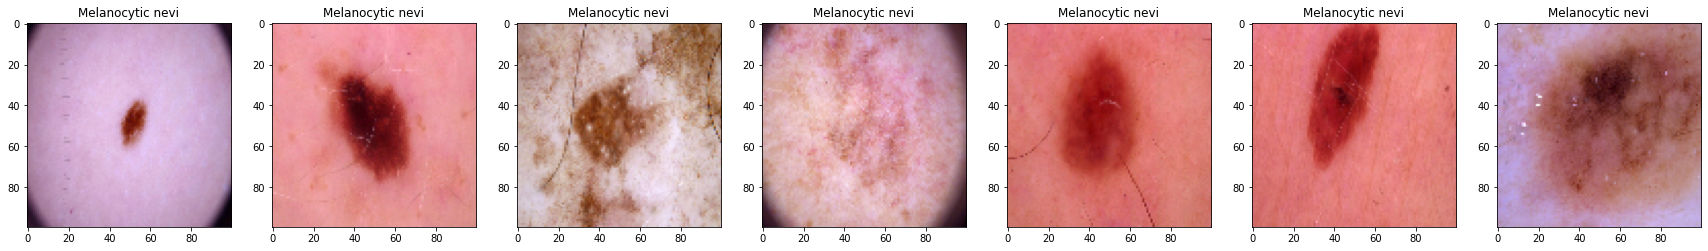

In [16]:

def show_figures(x,y) -> None:
    rand=random.randint(0,len(x))
    """ Display figuers of the classes. """
    # Figure, Axes
    _, ax = plt.subplots(1, 7, figsize = (30, 30))
    for i,j in zip(range(7),range(rand,rand+7)):                             
        ax[i].imshow(x[j])                                # Display the img.
        ax[i].set_title(lesion_names[int(y[j])])    # Set image title.

show_figures(x,y)

From the Above distribution, it is evident of class imbalance, Hence we will use both under-sampling(removing samples of major class) and over sampling (augmenting/increasing samples of minor class)

## Train Test Split

In [17]:
# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(x,                  # Images array.
                                                    y,            # The training set.
                                                    test_size = 0.20,   # Split data set into 80/20
                                                    random_state = 50,  # Shuffling number to random the set.
                                                    stratify = y,
                                                    shuffle=True)       # Mix training and test sets.


In [18]:
# split in 80% training and 20% test data
X_train, X_val, y_train, y_val = train_test_split(X_train,                  # Images array.
                                                    y_train,            # The training set.
                                                    test_size = 0.20,   # Split data set into 90/10.
                                                    random_state = 50,  # Shuffling number to random the set.
                                                    stratify = y_train,
                                                    shuffle=True)       # Mix training and test sets.


In [19]:

# [+] Display the count of train/test data set.
print('Train dataset shape', X_train.shape)
print('Val dataset shape', X_val.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (11569, 100, 100, 3)
Val dataset shape (2893, 100, 100, 3)
Test dataset shape (3616, 100, 100, 3)


In [20]:
# [+] Display the count of train/test data set.
print('Train Labels Count', y_train.shape)
print('Val Labels Count', y_val.shape)
print('Test Labels Count', y_test.shape)

Train Labels Count (11569,)
Val Labels Count (2893,)
Test Labels Count (3616,)


### Class Weights
This is done to mitigate the slight Imbalance in the two classes

In [21]:
def est_class_weights(dis_id: np.array) -> dict:
    """Estimate class weights for unbalanced datasets.

    Args:
        dis_id (np.array): numpy array of dis IDs

    Returns:
        dict: Estimated class weights for for unbalanced datasets.
    """
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = dis_id), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))
    
    return class_weights

y_id = (y_train)
new_class_weights = est_class_weights(y_id)
print('The problem is unbalanced. We need to provide class-weights')
print(new_class_weights)

The problem is unbalanced. We need to provide class-weights
{0: 1.12, 1: 0.9}


## Model Building

### The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on multi-layer perceptrons (MLPs), that contains two types of MLP layers:

One applied independently to image patches, which mixes the per-location features.
The other applied across patches (along channels), which mixes spatial information.
This is similar to a depthwise separable convolution based model such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization instead of batch normalization.

### Baseline Model

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

### Configure the hyperparameters

In [23]:
weight_decay = 0.0001
num_epochs = 20
dropout_rate = 0.1
image_size = 100  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 512  # Number of hidden units.
num_blocks = 8   # Number of blocks.
learning_rate=0.001

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 100 X 100 = 10000
Patch size: 8 X 8 = 64 
Patches per image: 144
Elements per patch (3 channels): 192


In [24]:
num_classes=1
batch_size=32
input_shape = (img_height,img_width,3)

### Implement patch extraction as a layer

In [25]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches,**kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches
    
    def get_config(self):

        config =super(Patches, self).get_config()
        config.update({
            'patch_size': self.patch_size,
            'num_patches': self.num_patches
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


### Implement the MLP-Mixer module

In [26]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=hidden_units),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

### Build a classification model

In [27]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size, num_patches)(inputs)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    #apply dropout
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    output = layers.Dense(1, activation="sigmoid")(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=output)

### Define an experiment

In [28]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate,weight_decay=weight_decay)
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy")
                ]
    )

        
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_lr=0.0000001,verbose=1)
    
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=20, restore_best_weights=True,mode="max"
    )
    
    #create a model checkpoint
    filepath='/kaggle/working/mlp-mixer.tf'
    checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath,
        monitor="val_accuracy",verbose=1, save_weights_only=False,mode="max",save_best_only = True )
                                                  
    # Fit the model.
    history = model.fit(x=X_train,y=y_train,
        batch_size=batch_size,
        shuffle=True,
        epochs=num_epochs,
        validation_data=(X_val,y_val),
        callbacks=[early_stopping,checkpoint,reduce_lr]
    )


    # Return history to plot learning curves.
    return history

### Build, train, and evaluate

In [29]:
#**** Training Block of Code ****
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
mlpmixer_classifier = build_classifier(mlpmixer_blocks)


2022-11-15 18:39:05.475664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:39:05.476692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:39:05.644963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:39:05.645869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:39:05.646688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [30]:
mlpmixer_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
patches (Patches)            (None, 144, 192)          0         
_________________________________________________________________
dense_32 (Dense)             (None, 144, 512)          98816     
_________________________________________________________________
sequential_16 (Sequential)   (None, 144, 512)          1527168   
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 513   

In [31]:
history = run_experiment(mlpmixer_classifier)

2022-11-15 18:39:13.284867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
362/362 [==============================] - 55s 126ms/step - loss: 8.0933 - accuracy: 0.7254 - val_loss: 0.5094 - val_accuracy: 0.7553

Epoch 00001: val_accuracy improved from -inf to 0.75527, saving model to /kaggle/working/mlp-mixer.tf


2022-11-15 18:40:16.305077: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
362/362 [==============================] - 45s 124ms/step - loss: 0.4389 - accuracy: 0.7936 - val_loss: 0.3715 - val_accuracy: 0.8158

Epoch 00002: val_accuracy improved from 0.75527 to 0.81576, saving model to /kaggle/working/mlp-mixer.tf
Epoch 3/20
362/362 [==============================] - 45s 125ms/step - loss: 0.3971 - accuracy: 0.8115 - val_loss: 0.5106 - val_accuracy: 0.7809

Epoch 00003: val_accuracy did not improve from 0.81576
Epoch 4/20
362/362 [==============================] - 45s 124ms/step - loss: 0.3645 - accuracy: 0.8301 - val_loss: 0.4082 - val_accuracy: 0.8296

Epoch 00004: val_accuracy improved from 0.81576 to 0.82959, saving model to /kaggle/working/mlp-mixer.tf
Epoch 5/20
362/362 [==============================] - 45s 124ms/step - loss: 0.3405 - accuracy: 0.8399 - val_loss: 0.4786 - val_accuracy: 0.7964

Epoch 00005: val_accuracy did not improve from 0.82959
Epoch 6/20
362/362 [==============================] - 45s 124ms/step - loss: 0.3136 - accuracy: 

In [32]:
loss,acc = mlpmixer_classifier.evaluate(X_test, y_test,verbose=1)
print('Accuracy on test data: '+ str(acc*100))
print('Loss on test data: ' + str(loss))


113/113 [==============================] - 6s 33ms/step - loss: 0.2916 - accuracy: 0.8733
Accuracy on test data: 87.33407258987427
Loss on test data: 0.2916260361671448


## Model Evaluation

113/113 [==============================] - 4s 31ms/step
Confusion Matrix


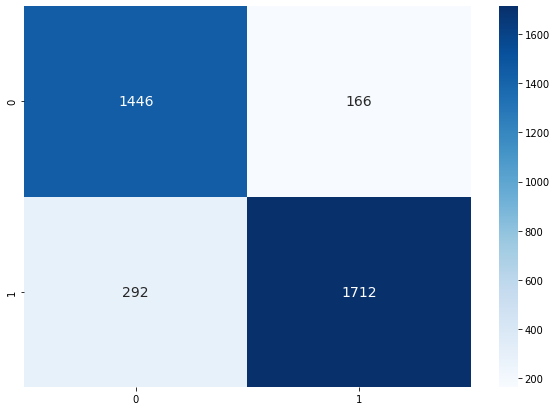

**************************************************
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1612
           1       0.91      0.85      0.88      2004

    accuracy                           0.87      3616
   macro avg       0.87      0.88      0.87      3616
weighted avg       0.88      0.87      0.87      3616

**************************************************


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#Confusion Matrix and Classification Report
y_pred = mlpmixer_classifier.predict(X_test,verbose=1,)
y_pred_= [1 if (x>=0.5)  else 0 for x in y_pred ]
labels=np.unique(df_skin['lesion_ID'])
print('Confusion Matrix')
cm=confusion_matrix(y_test, y_pred_)
plt.figure(figsize=(10,7))
sns.heatmap(cm,cmap='Blues',annot=True,fmt="g",annot_kws={'size':14})
plt.show()
print("*"*50)
print('Classification Report')
print(classification_report(y_test, y_pred_))
print("*"*50)

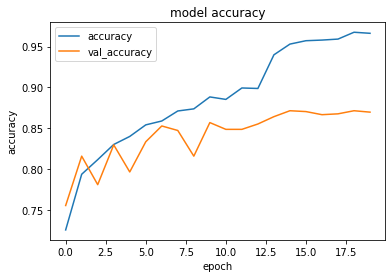

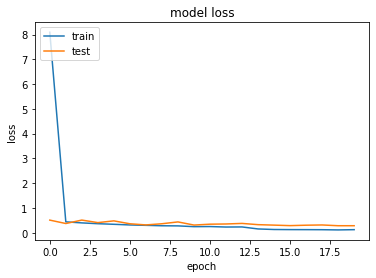

In [34]:

def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()

## Hyper-Parameter Tuning and Optimization

We will use Keras Tuner to optimize Model and choose the best parameters.

In [35]:
#installing Keras tuner
!pip install keras-tuner -q

In [36]:
import keras_tuner as kt

In [37]:
def build_model(hp):
    hp_weight_decay = 0.0001
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.1,0.2,0.3])
    hp_image_size = 100  # We'll resize input images to this size.
    hp_patch_size =  hp.Choice('patch_size', values=[8,16,32]) # Size of the patches to be extracted from the input images.
    hp_num_patches = (hp_image_size // hp_patch_size) ** 2  # Size of the data array.
    hp_embedding_dim = hp.Choice('embedding_dim', values=[256,384,512])  # Number of hidden units.
    hp_num_blocks = hp.Choice('num_blocks', values=[4,6,8,10])   # Number of blocks.
    hp_learning_rate=0.0001
    positional_encoding=False
    blocks=keras.Sequential([MLPMixerLayer(hp_num_patches, hp_embedding_dim, hp_dropout_rate) for _ in range(hp_num_blocks)])
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    hp_patches = Patches(hp_patch_size, hp_num_patches)(inputs)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=hp_embedding_dim)(hp_patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=hp_num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=hp_num_patches, output_dim=hp_embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    #apply dropout
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute sigmoid outputs.
    output = layers.Dense(1, activation="sigmoid")(representation)
    # Create the Keras model.                              
    classifier= keras.Model(inputs=inputs, outputs=output)
    classifier.compile(optimizer=tfa.optimizers.AdamW(
                                learning_rate=hp_learning_rate, 
                                weight_decay=hp_weight_decay),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")])
        
    return classifier

In [38]:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_epochs=30,
    directory='/kaggle/working/keras-tuner',
    project_name='keras_tuner_mlp_1')

In [39]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val,y_val),callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Trial 90 Complete [00h 06m 02s]
val_accuracy: 0.8233667612075806

Best val_accuracy So Far: 0.8496370315551758
Total elapsed time: 03h 24m 12s


In [40]:
tuner.results_summary(1) #Get the hyperparameters for best score . 1

Results summary
Results in /kaggle/working/keras-tuner/keras_tuner_mlp_1
Showing 1 best trials
Trial summary
Hyperparameters:
dropout_rate: 0.1
patch_size: 8
embedding_dim: 512
num_blocks: 6
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8496370315551758


Hyperparameters With Best Score:
* dropout_rate: 0.1
* patch_size: 8
* embedding_dim: 384
* num_blocks: 8
* tuner/epochs: 30

**Score: 0.85**

## Creating and Train Model with these new Hyperparameters

In [41]:
res=tuner.get_best_hyperparameters()[0].values

In [42]:
res #parameters stored in dictionary

{'dropout_rate': 0.1,
 'patch_size': 8,
 'embedding_dim': 512,
 'num_blocks': 6,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [43]:
weight_decay=0.0001
dropout_rate=res['dropout_rate']
patch_size=res['patch_size']
embedding_dim=res['embedding_dim']
num_blocks=res['num_blocks']
learning_rate=0.001
num_patches = (image_size // patch_size) ** 2 
epochs=50

### Run the Experiment

In [44]:
def run_best_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy")
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_lr=0.00000000+1,verbose=1)
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=20, restore_best_weights=True,mode="max"
    )
    
    #create a model checkpoint
    filepath='/kaggle/working/mlp-mixer_optimized.tf'
    checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath,
        monitor="val_accuracy",verbose=1, save_weights_only=False,mode="max",save_best_only = True )
                                                  
    # Fit the model.
    history = model.fit(x=X_train,y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data = (X_val,y_val),
        callbacks=[early_stopping, reduce_lr,checkpoint],
        class_weight=new_class_weights
    )


    # Return history to plot learning curves.
    return history

### Training the model

In [45]:
#**** Training Block of Code ****
mlpmixer_blocks_opt = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
mlpmixer_classifier_opt = build_classifier(mlpmixer_blocks_opt)


In [46]:
history_opt = run_best_experiment(mlpmixer_classifier_opt)

Epoch 1/50
362/362 [==============================] - 42s 97ms/step - loss: 11.7611 - accuracy: 0.7270 - val_loss: 0.6684 - val_accuracy: 0.7110

Epoch 00001: val_accuracy improved from -inf to 0.71103, saving model to /kaggle/working/mlp-mixer_optimized.tf
Epoch 2/50
362/362 [==============================] - 34s 94ms/step - loss: 0.4495 - accuracy: 0.7900 - val_loss: 0.4257 - val_accuracy: 0.8019

Epoch 00002: val_accuracy improved from 0.71103 to 0.80194, saving model to /kaggle/working/mlp-mixer_optimized.tf
Epoch 3/50
362/362 [==============================] - 34s 94ms/step - loss: 0.4022 - accuracy: 0.8070 - val_loss: 0.4245 - val_accuracy: 0.8047

Epoch 00003: val_accuracy improved from 0.80194 to 0.80470, saving model to /kaggle/working/mlp-mixer_optimized.tf
Epoch 4/50
362/362 [==============================] - 34s 94ms/step - loss: 0.3716 - accuracy: 0.8235 - val_loss: 0.3880 - val_accuracy: 0.8199

Epoch 00004: val_accuracy improved from 0.80470 to 0.81991, saving model to /

In [47]:
loss,acc = mlpmixer_classifier_opt.evaluate(X_test, y_test,verbose=1)
print('Accuracy on test data: %.2f'%(acc*100))
print('Loss on test data: %.2f'%loss)


113/113 [==============================] - 4s 26ms/step - loss: 0.7933 - accuracy: 0.8404
Accuracy on test data: 84.04
Loss on test data: 0.79


### Model Evaluation

113/113 [==============================] - 3s 24ms/step
Confusion Matrix


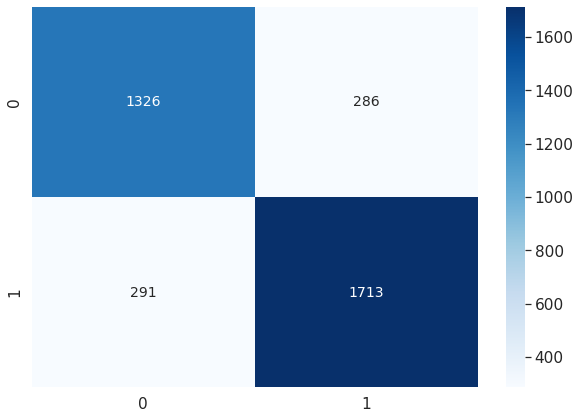

**************************************************
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1612
           1       0.86      0.85      0.86      2004

    accuracy                           0.84      3616
   macro avg       0.84      0.84      0.84      3616
weighted avg       0.84      0.84      0.84      3616

**************************************************


In [48]:
#Confusion Matrix and Classification Report
y_pred = mlpmixer_classifier_opt.predict(X_test,verbose=1,)
y_pred_= [1 if (x>=0.5)  else 0 for x in y_pred ]
labels=np.unique(df_skin['lesion_ID'])
print('Confusion Matrix')
cm=confusion_matrix(y_test, y_pred_)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(cm,cmap='Blues',annot=True,fmt="g",annot_kws={'size':14})
plt.show()
print("*"*50)
print('Classification Report')
print(classification_report(y_test, y_pred_))
print("*"*50)


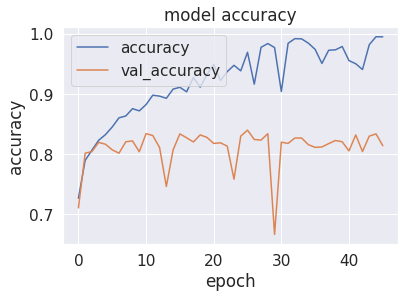

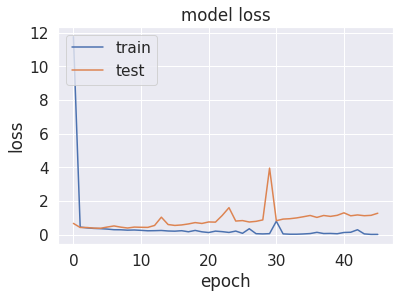

In [49]:

def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history_opt.history['accuracy'])
    plt.plot(history_opt.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history_opt.history['loss'])
    plt.plot(history_opt.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()